___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [30]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
# You can install torchmeterics using: pip install torchmetrics

In [31]:
plt.rcParams['text.usetex'] = False

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [32]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cuda


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [34]:
# Loading TIFF images for Super-resolution
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
    
    # Get the number of samples in the dataset
    def __len__(self):
        return len(self.filenames)

    # Get the sample at the given index
    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        # Load images
        high_res = Image.open(high_res_path)
        low_res = Image.open(low_res_path)

        # Resize low-res to 128x128 (ensuring correct input size)
        low_res = low_res.resize((128, 128), Image.BICUBIC)

        # Apply transformations
        if self.transform:
            high_res = self.transform(high_res)
            low_res = self.transform(low_res)

        return low_res, high_res  # Returning input-output pairs

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform)

# Function to create data loader
def create_loader(dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset size
dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)


Number of images in the dataset: 240


___
### Define a super-resolution network

#### Here, I have defined a trivial network, which has only two layers and no activation function. We are essentially doing linear filtering.

In [35]:
class ConvBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(mid_channels), # Optional: Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(out_channels), # Optional: Batch Normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Use ConvTranspose2d for upsampling
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels) # Input channels to ConvBlock is in_channels (skip + upsampled)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Pad x1 to match x2 size
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512) # Bottleneck starts after this

        # Decoder
        # Note: The input channels for Up block = channels from previous Up layer + channels from corresponding Down layer skip connection
        self.up1 = Up(512, 256) # Upsample from 512 to 256, concat with down2 (256), output 256 channels
        self.up2 = Up(256, 128) # Upsample from 256 to 128, concat with down1 (128), output 128 channels
        self.up3 = Up(128, 64)  # Upsample from 128 to 64, concat with inc (64), output 64 channels

        # Final Convolution
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)    # Input: 128x128x1 -> Output: 128x128x64
        x2 = self.down1(x1) # Input: 128x128x64 -> Output: 64x64x128
        x3 = self.down2(x2) # Input: 64x64x128 -> Output: 32x32x256
        x4 = self.down3(x3) # Input: 32x32x256 -> Output: 16x16x512 (Bottleneck)

        # Decoder path
        x = self.up1(x4, x3) # Input: 16x16x512, Skip: 32x32x256 -> Output: 32x32x256
        x = self.up2(x, x2)  # Input: 32x32x256, Skip: 64x64x128 -> Output: 64x64x128
        x = self.up3(x, x1)  # Input: 64x64x128, Skip: 128x128x64 -> Output: 128x128x64

        # Upsample to the target size (256x256)
        # The final upsampling happens here, before the last convolution
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True) # Input: 128x128x64 -> Output: 256x256x64

        logits = self.outc(x) # Input: 256x256x64 -> Output: 256x256x1
        return logits

___
### Create a function to execute training. Note, we will call this function later.

In [36]:
def train_model(model, opt, criterion, train_loader, num_epoch):
    avg_train_losses = []

    for epoch in range(num_epoch):  # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0

        for i, (x_tr_batch, y_tr_batch) in enumerate(train_loader):  # Loop over mini-batches
            x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

            # --- Removed Interpolation ---
            # The U-Net model now takes 128x128 input directly
            # x_tr_batch = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bicubic', align_corners=False)

            opt.zero_grad()  # Delete previous gradients
            y_hat_tr_batch = model(x_tr_batch)  # Forward pass (Input: 128x128, Output: 256x256)
            loss = criterion(y_hat_tr_batch, y_tr_batch)  # Compute loss (comparing 256x256 output with 256x256 target)
            loss.backward()  # Backward pass
            opt.step()  # Update weights
            total_train_loss += loss.item()  # Accumulate loss

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)  # Compute average loss
        avg_train_losses.append(avg_train_loss)  # Store average loss

    # Plot training loss
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch + 1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')  # Log scale for better visualization
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Epoch 1, Iteration 10, Loss: 0.084766
Epoch 1, Iteration 20, Loss: 0.012031
Epoch 1, Iteration 30, Loss: 0.006462
Epoch 1, Iteration 40, Loss: 0.004944
Epoch 2, Iteration 10, Loss: 0.005067
Epoch 2, Iteration 20, Loss: 0.004011
Epoch 2, Iteration 30, Loss: 0.004175
Epoch 2, Iteration 40, Loss: 0.003273
Epoch 3, Iteration 10, Loss: 0.002851
Epoch 3, Iteration 20, Loss: 0.002913
Epoch 3, Iteration 30, Loss: 0.002507
Epoch 3, Iteration 40, Loss: 0.002080
Epoch 4, Iteration 10, Loss: 0.002022
Epoch 4, Iteration 20, Loss: 0.002144
Epoch 4, Iteration 30, Loss: 0.002007
Epoch 4, Iteration 40, Loss: 0.001938
Epoch 5, Iteration 10, Loss: 0.001736
Epoch 5, Iteration 20, Loss: 0.001572
Epoch 5, Iteration 30, Loss: 0.001697
Epoch 5, Iteration 40, Loss: 0.001410
Epoch 6, Iteration 10, Loss: 0.001576
Epoch 6, Iteration 20, Loss: 0.001406
Epoch 6, Iteration 30, Loss: 0.001545
Epoch 6, Iteration 40, Loss: 0.001367
Epoch 7, Iteration 10, Loss: 0.001320
Epoch 7, Iteration 20, Loss: 0.001348
Epoch 7, Ite

findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Fo

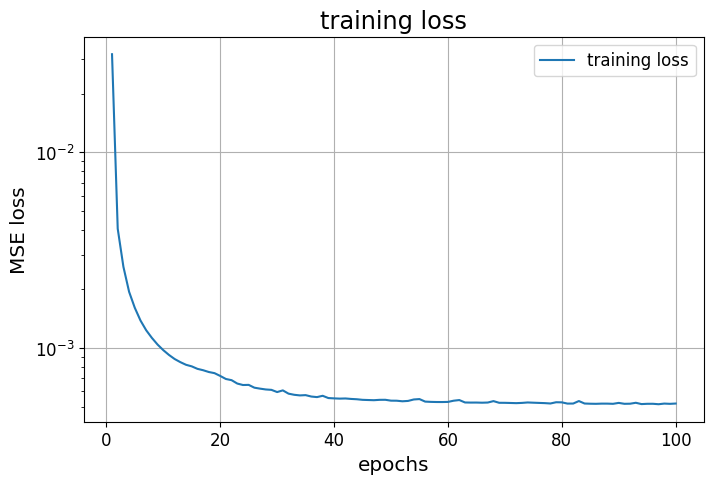

In [37]:
batch_size = 5  # Number of complete images in each batch
lr = 1e-4  # Learning rate (Adjust as needed for U-Net)
num_epoch = 100  # Epochs (Adjust as needed)

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = UNet(n_channels=1, n_classes=1).to(device)  # Use UNet model
opt = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer is common for U-Nets
criterion = nn.MSELoss()  # Mean Squared Error Loss

# Train the model
train_model(model, opt, criterion, train_loader, num_epoch)

___
### Apply it one of the validation image

findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Fo

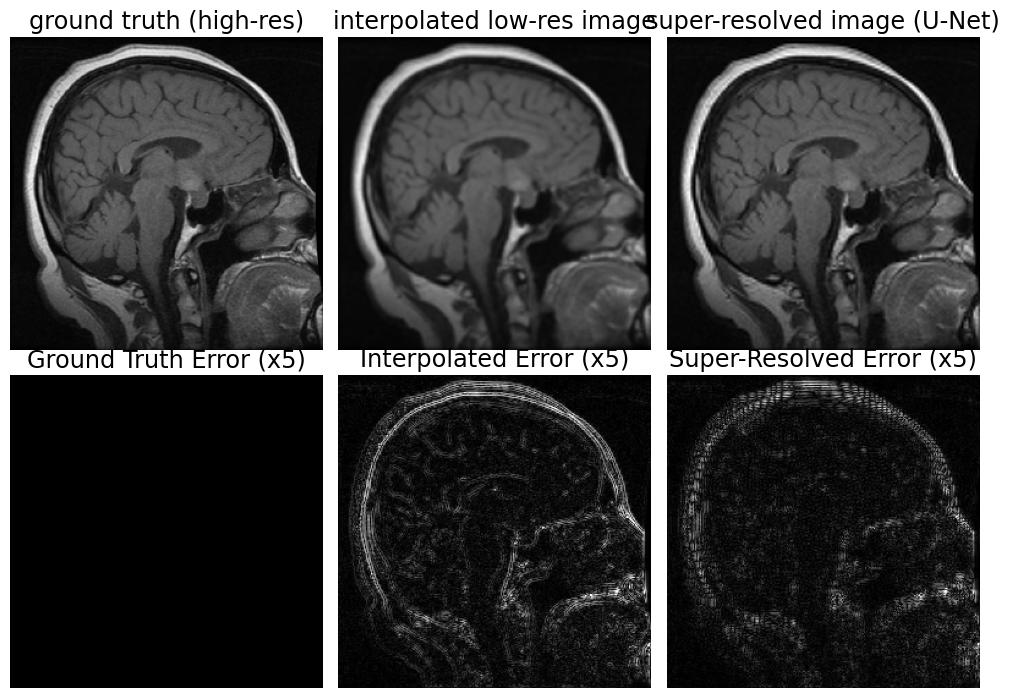

In [38]:
# Create the dataset for validation images
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform)

# Load one (low-res, high-res) image pair from validation dataset and move it to the device
val_low_res, val_high_res = val_dataset[1]  # Input (1x128x128), Ground truth (1x256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Upsample low-resolution image to 256x256 *only for visualization comparison*
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)

# Apply the trained model to the *original* low-res image (128x128)
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    # Add batch dimension to low-res input
    val_super_res = model(val_low_res.unsqueeze(0)).squeeze(0)  # Input: 1x1x128x128 -> Output: 1x1x256x256 -> Squeeze: 1x256x256

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the *interpolated* version for visualization
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_super_res_np = val_super_res.squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('ground truth (high-res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('interpolated low-res image')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('super-resolved image (U-Net)')
ax[0, 2].axis('off')

# Error maps (Multiplied by 5 for visibility)
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].set_title('Ground Truth Error (x5)')
ax[1, 0].axis('off')
# ax[1, 0].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].set_title('Interpolated Error (x5)')
ax[1, 1].axis('off')
# ax[1, 1].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].set_title('Super-Resolved Error (x5)')
ax[1, 2].axis('off')
# ax[1, 2].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()


### Compute PSNR and SSIM over the entire validation dataset

In [39]:
# Initialize metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device) # Set initial data_range, can be updated

# Accumulators
total_psnr_interpolated = 0
total_psnr_super_resolved = 0
total_ssim_interpolated = 0
total_ssim_super_resolved = 0
num_samples = len(val_dataset)

model.eval() # Ensure model is in evaluation mode
with torch.no_grad(): # Disable gradients for evaluation
    # Loop over validation set
    for i in range(num_samples):
        val_low_res, val_high_res = val_dataset[i]
        val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

        # Add batch dimension for model input and metrics
        val_low_res_batch = val_low_res.unsqueeze(0) # Shape: [1, 1, 128, 128]
        val_high_res_batch = val_high_res.unsqueeze(0) # Shape: [1, 1, 256, 256]

        # Compute data range dynamically for SSIM (important if images aren't normalized 0-1)
        # If images are guaranteed to be normalized [0, 1], setting data_range=1.0 once is sufficient.
        data_range = val_high_res.max() - val_high_res.min()
        ssim_metric.data_range = data_range

        # --- Evaluation for Interpolated Image ---
        # Upsample low-res image using interpolation *for comparison*
        val_low_res_interpolated_batch = torch.nn.functional.interpolate(val_low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)

        # PSNR for interpolated
        psnr_interp = psnr_metric(val_low_res_interpolated_batch, val_high_res_batch).item()

        # SSIM for interpolated
        ssim_interp = ssim_metric(val_low_res_interpolated_batch, val_high_res_batch).item()


        # --- Evaluation for Super-Resolved Image (U-Net) ---
        # Get super-resolved image from the model using the original low-res input
        val_super_res_batch = model(val_low_res_batch) # Input: [1, 1, 128, 128] -> Output: [1, 1, 256, 256]

        # PSNR for super-resolved
        psnr_sr = psnr_metric(val_super_res_batch, val_high_res_batch).item()

        # SSIM for super-resolved
        ssim_sr = ssim_metric(val_super_res_batch, val_high_res_batch).item()


        # Accumulate metrics
        total_psnr_interpolated += psnr_interp
        total_psnr_super_resolved += psnr_sr
        total_ssim_interpolated += ssim_interp
        total_ssim_super_resolved += ssim_sr

# Averages
avg_psnr_interp = total_psnr_interpolated / num_samples
avg_psnr_sr = total_psnr_super_resolved / num_samples
avg_ssim_interp = total_ssim_interpolated / num_samples
avg_ssim_sr = total_ssim_super_resolved / num_samples

# Calculate the combined score for the super-resolved images
score_sr = avg_psnr_sr + 40 * avg_ssim_sr
score_interp = avg_psnr_interp + 40 * avg_ssim_interp


# Print results
print(f'--- Validation Set Performance ---')
print(f'Average PSNR (Bicubic Interpolated): {avg_psnr_interp:.2f} dB')
print(f'Average PSNR (U-Net Super-Resolved): {avg_psnr_sr:.2f} dB')
print(f'Average SSIM (Bicubic Interpolated): {avg_ssim_interp:.4f}')
print(f'Average SSIM (U-Net Super-Resolved): {avg_ssim_sr:.4f}')
print(f'Combined Score (Interpolated): {score_interp:.2f}')
print(f'Combined Score (U-Net Super-Resolved): {score_sr:.2f}')

--- Validation Set Performance ---
Average PSNR (Bicubic Interpolated): 30.81 dB
Average PSNR (U-Net Super-Resolved): 32.93 dB
Average SSIM (Bicubic Interpolated): 0.9056
Average SSIM (U-Net Super-Resolved): 0.9409
Combined Score (Interpolated): 67.04
Combined Score (U-Net Super-Resolved): 70.57
